In [72]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
import json
import yapf.yapflib.yapf_api
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [73]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")

In [74]:
# change field 38 to 3 groups
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

In [75]:
data["FIELD_6_7"] = np.min(
    data[["FIELD_6", "FIELD_7"]], axis=1
)  # combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)

data = data.drop(columns=["FIELD_6", "FIELD_7", "B_DAY"])
print(data.shape)

(535169, 405)


In [76]:
# add Class to the dataset
_class = []
for i in range(data.shape[0]):
    if (data.S000501[i] >= 140) | (data.S000502[i] >= 90):
        _class.append(2)
    elif (data.S000501[i] < 120) & (data.S000502[i] < 80):
        _class.append(0)
    else:
        _class.append(1)
data["CLASS"] = _class

In [77]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  

print(data.shape)

(465879, 406)


In [78]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [79]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

In [9]:
print(data.shape)
print(data.groupby(by='CLASS').size())

mydata=data.copy()
class2 = mydata[mydata.CLASS == 2]
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

data = pd.concat([class2, class1.sample(class2.shape[0],random_state=42), 
                  class0.sample(class2.shape[0],random_state=42)])

print(data.shape)

(465879, 406)
CLASS
0    239294
1    208467
2     18118
dtype: int64
(54354, 406)


2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [10]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

,Col,val
139,L403300,1.0
43,L105300,1.0
263,S004422,1.0
262,S004421,1.0
261,S004420,1.0


In [11]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,Unnamed: 0,54354
1,COMPARE,54354
2,AGE,54354
3,L100100,51902
4,L100200,51948


In [12]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 50000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(10)

,Col,val,Count
10,CLASS,1.000000,54354
13,SBP,0.860218,54321
14,DBP,0.825214,54321
21,BMI,0.433475,54221
31,Hemoglobin,0.325775,54291
32,RBC,0.322953,54191
35,HCT,0.315204,54170
37,Uric Acid,0.291779,52041
38,fasting glucose,0.285393,54291
39,Triglycerides,0.281977,54184


In [13]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'SBP', 'DBP', 'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'r-GTP gamma', 'AGE', 'L101600', 'total cholesterol', 'L100500', 'HDL-Cholesterol']


2.1.2 Anova test
=======

In [14]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b, temp[temp["a"] == 2].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [15]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [16]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 40000].Cols)[:25])
FvalPvalCorr[FvalPvalCorr.Count > 40000].head(30)

['CLASS', 'SBP', 'DBP', 'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol', 'S000100', 'SGPT', 'L101400', 'L190000', 'L190800', 'L504700']


,Cols,F,P,Count
274,CLASS,inf,0.000000e+00,54354
212,SBP,7.860757e+04,0.000000e+00,54321
213,DBP,5.797356e+04,0.000000e+00,54321
210,BMI,6.373788e+03,0.000000e+00,54221
91,Hemoglobin,3.546321e+03,0.000000e+00,54291
90,RBC,3.457629e+03,0.000000e+00,54191
92,HCT,3.311376e+03,0.000000e+00,54170
8,Uric Acid,2.603384e+03,0.000000e+00,52041
9,fasting glucose,2.409381e+03,0.000000e+00,54291
24,Triglycerides,2.341443e+03,0.000000e+00,54184


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [80]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [81]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [82]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,FIELD_6_7,CLASS,SEX
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,0.0


In [83]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,FIELD_6_7,CLASS,SEX
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,0.0


In [21]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]
        class2_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 2"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count + class2_count)

        temptable.append([class0_count, class1_count, class2_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

0 Blood_factor_RH_factor
1 blood_type
2 FIELD_5
3 FIELD_9
4 FIELD_13
5 Whether_one_diagnosis_disease
6 FIELD_15
7 FIELD_16
8 FIELD_17
9 FIELD_18
10 _1_drug_therapy_stroke
11 FIELD_20
12 _1_medication_heart_disease
13 FIELD_22
14 FIELD_23
15 FIELD_24
16 FIELD_25
17 FIELD_26
18 _2_family_history_stroke
19 FIELD_28
20 _2_family_history_hypertension
21 FIELD_30
22 Family_history
23 _3B_hepatitis
24 _4_1_Smoking
25 FIELD_34
26 FIELD_35
27 FIELD_36
28 FIELD_37
29 Drinking_5_1_days
30 _6_1_of_physical_activity_high_strength
31 _6_2_of_physical_activity_moderate
32 _6_3_of_physical_activity_walking
33 FIELD_43
34 FIELD_44
35 FIELD_45
36 FIELD_46
37 FIELD_47
38 FIELD_48
39 FIELD_49
40 FIELD_50
41 FIELD_51
42 FIELD_52
43 FIELD_53
44 FIELD_54
45 FIELD_55
46 FIELD_56
47 FIELD_57
48 FIELD_58
49 FIELD_59
50 FIELD_60
51 FIELD_61
52 FIELD_62
53 FIELD_63
54 FIELD_64
55 FIELD_65
56 FIELD_66
57 FIELD_67
58 FIELD_68
59 FIELD_69
60 FIELD_72
61 FIELD_73
62 FIELD_74
63 FIELD_75
64 FIELD_76
65 FIELD_77
66 FIE

In [22]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [23]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 40000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:15]))
finalstat[["Name", "stat", "instances"]].head(10)

['CLASS', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_6_3_of_physical_activity_walking', 'blood_type', '_3B_hepatitis', 'FIELD_28', 'FIELD_13', '_1_medication_heart_disease']


,Name,stat,instances
103,CLASS,108702,54351
104,SEX,5267,54351
17,_4_1_Smoking,2024,53973
22,Drinking_5_1_days,1730,50780
101,FIELD_38_C,1098,50780
23,_6_1_of_physical_activity_high_strength,344,50781
13,_2_family_history_hypertension,243,53990
24,_6_2_of_physical_activity_moderate,202,50782
11,_2_family_history_stroke,123,53937
25,_6_3_of_physical_activity_walking,65,50771


3 Refine the selected numerical and categorical features
====

In [27]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 
    'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol', 
    'S000100', 'SGPT', 'L101400', 'L190000', 'L190800', 'L504700','SEX', '_4_1_Smoking', 'Drinking_5_1_days', 
    'FIELD_38_C', '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', 
    '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_6_3_of_physical_activity_walking', 
    'blood_type', '_3B_hepatitis', 'FIELD_28', 'FIELD_13', '_1_medication_heart_disease',
    "CLASS",
]

In [28]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()

print(mydata.shape)

(30609, 37)


In [29]:
x = mydata[
    [
    'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 
    'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol', 
    'S000100', 'SGPT', 'L101400', 'L190000', 'L190800', 'L504700','SEX', '_4_1_Smoking', 'Drinking_5_1_days', 
    'FIELD_38_C', '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', 
    '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_6_3_of_physical_activity_walking', 
    'blood_type', '_3B_hepatitis', 'FIELD_28', 'FIELD_13', '_1_medication_heart_disease',
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

(30609, 36)


,BMI,Hemoglobin,RBC,HCT,Uric Acid,fasting glucose,Triglycerides,Cardiac risk factor,r-GTP gamma,AGE,...,_2_family_history_hypertension,_6_2_of_physical_activity_moderate,_2_family_history_stroke,_6_3_of_physical_activity_walking,blood_type,_3B_hepatitis,FIELD_28,FIELD_13,_1_medication_heart_disease,CLASS
4,23.7,13.7,4.34,40.4,2.8,118.0,92.0,3.5,24.0,50.0,...,0.0,2.0,0.0,2.0,4,3.0,0.0,0.0,0.0,2
50,21.7,12.3,4.47,39.0,2.5,95.0,64.0,3.0,12.0,46.0,...,1.0,3.0,0.0,3.0,3,2.0,0.0,0.0,0.0,2
82,26.4,16.3,5.34,49.1,8.4,98.0,187.0,4.0,40.0,48.0,...,0.0,0.0,0.0,3.0,4,3.0,0.0,0.0,0.0,2
83,26.3,15.5,5.17,46.8,9.2,104.0,99.0,3.7,41.0,49.0,...,0.0,2.0,0.0,3.0,4,3.0,0.0,0.0,0.0,2
84,26.8,15.5,5.27,47.3,8.6,90.0,121.0,3.7,37.0,50.0,...,1.0,1.0,1.0,2.0,4,3.0,1.0,0.0,0.0,2


3.1 ExtraTreesClassifier feature_importances method
========================

[0.05958803 0.04350287 0.03384907 0.03118644 0.03496185 0.03657151
 0.03495783 0.03227676 0.03555128 0.0474115  0.03158153 0.03222184
 0.03300692 0.03367165 0.02772841 0.02988427 0.03102286 0.03192114
 0.03372525 0.03014712 0.02939598 0.029453   0.02941543 0.01900669
 0.02133134 0.01316075 0.02366326 0.01051091 0.02588565 0.0092275
 0.02724305 0.02637612 0.02143476 0.00820323 0.         0.00092421]


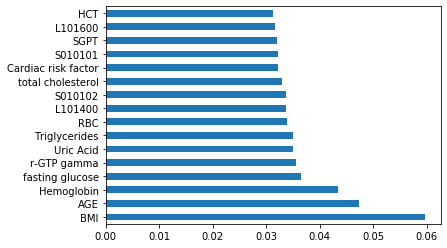

Index(['BMI', 'AGE', 'Hemoglobin', 'fasting glucose', 'r-GTP gamma',
       'Uric Acid', 'Triglycerides', 'RBC', 'L101400', 'S010102',
       'total cholesterol', 'Cardiac risk factor', 'S010101', 'SGPT',
       'L101600', 'HCT', 'S000100'],
      dtype='object')


In [30]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(17).index)

3.2 SelectKBest method
=========

In [31]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:16]))

['BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol']


3.3 variance inflation factor 
=============

In [32]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [31]:
# the new columns are selcted from section 3.2
# newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
#                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

newcols = vifcal(
    mydata[
        [
        'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 
    'r-GTP gamma', 'AGE', 'L101600', 'total cholesterol', 'L100500', 'HDL-Cholesterol', 
    'SGPT', 'L101400', 'L190000', 'L190800',
    'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', 
    '_2_family_history_stroke', '_6_3_of_physical_activity_walking', '_3B_hepatitis', 'FIELD_28', 
    '_1_medication_heart_disease',
            "CLASS",
        ]
    ],
    "CLASS",
)
print(newcols, len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100

KeyError: "['HCT', 'total cholesterol', 'Cardiac risk factor', 'L190800', 'RBC', 'Hemoglobin', 'HDL-Cholesterol'] not in index"

3.4 Final Selected Features
======

In [228]:
# based on the out put of section of 3.2 and 3.3 the following features are selected


finalFeatures = [
    'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 
    'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol', 
    'S000100', 'SGPT', 'L101400', 'L190000', 'L190800', 'L504700','SEX', '_4_1_Smoking', 'Drinking_5_1_days', 
    'FIELD_38_C', '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', 
    '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_6_3_of_physical_activity_walking', 
    '_3B_hepatitis', 'FIELD_28', 'FIELD_13', '_1_medication_heart_disease',
    "CLASS"
]



# finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid',
#                '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']

In [229]:
# finalFeatures=['L500800', 'L500900', 'L533900', 'L540100', 'S010101', 'S010102', 'Triglycerides', 
#                'HDL-Cholesterol', 'L103200', 'Cardiac risk factor', 'CLASS']


Classifier Model Test Based on the features 
========

In [230]:
data.shape

(465879, 406)

In [324]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(266676, 36)


,BMI,Hemoglobin,RBC,HCT,Uric Acid,fasting glucose,Triglycerides,Cardiac risk factor,r-GTP gamma,AGE,...,_6_1_of_physical_activity_high_strength,_2_family_history_hypertension,_6_2_of_physical_activity_moderate,_2_family_history_stroke,_6_3_of_physical_activity_walking,_3B_hepatitis,FIELD_28,FIELD_13,_1_medication_heart_disease,CLASS
2,24.3,13.4,4.24,40.7,2.6,113.0,75.0,2.9,36.0,48.0,...,3.0,0.0,3.0,0.0,3.0,2.0,0.0,0.0,0.0,1
4,23.7,13.7,4.34,40.4,2.8,118.0,92.0,3.5,24.0,50.0,...,2.0,0.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,2
6,21.2,15.1,4.72,44.9,5.1,87.0,109.0,3.3,36.0,49.0,...,4.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0
7,25.1,15.4,5.19,45.9,7.9,96.0,92.0,3.9,40.0,46.0,...,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,1
9,18.0,14.2,4.34,41.7,5.6,88.0,60.0,2.4,24.0,46.0,...,1.0,0.0,1.0,0.0,7.0,1.0,0.0,0.0,0.0,1


In [325]:
mydata.groupby(by='CLASS').size()

CLASS
0    137102
1    119124
2     10450
dtype: int64

In [326]:
class2 = mydata[mydata.CLASS == 2]
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class2.shape[0], class1.shape[0], class0.shape[0])

10450 119124 137102


In [327]:
class2_test = class2.sample(1000, random_state=randomseed)
class1_test = class1.sample(1000, random_state=randomseed)
class0_test = class0.sample(1000, random_state=randomseed)
test = pd.concat([class2_test, class1_test, class0_test])
test=shuffle(test)

class2_train = class2.drop(class2_test.index)

class1_train = class1.drop(class1_test.index) .sample( class2_train.shape[0], random_state=randomseed)

class0_train = class0.drop(class0_test.index) .sample( class2_train.shape[0], random_state=randomseed)
train = pd.concat([class2_train, class1_train, class0_train])
train=shuffle(train)

In [328]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[5, 6, 7, 8])
# X_res, y_res = sm.fit_resample(train.iloc[:, :-1], train.iloc[:, -1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train = pd.DataFrame(X_res, columns=list(train.columns[:-1]))
# train["CLASS"] = y_res

In [329]:
# from sklearn.preprocessing import RobustScaler

# transformer = RobustScaler()
# transformer.fit(train.iloc[:, :-1])
# train.iloc[:, :-1] = transformer.transform(train.iloc[:, :-1])
# test.iloc[:, :-1] = transformer.transform(test.iloc[:, :-1])

In [330]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=randomseed, n_estimators=100, max_depth=10)
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.5683333333333334


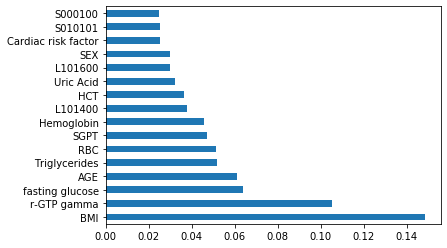

Index(['BMI', 'r-GTP gamma', 'fasting glucose', 'AGE', 'Triglycerides', 'RBC',
       'SGPT', 'Hemoglobin', 'L101400', 'HCT', 'Uric Acid', 'L101600', 'SEX',
       'Cardiac risk factor', 'S010101', 'S000100'],
      dtype='object')
0.8161848044662015


In [238]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [239]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[644, 260,  96],
       [232, 412, 356],
       [108, 243, 649]], dtype=int64)

In [240]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.718
Accuracy on test set: 0.568


,0,1,2
0,644,260,96
1,232,412,356
2,108,243,649


In [241]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1000
           1       0.45      0.41      0.43      1000
           2       0.59      0.65      0.62      1000

    accuracy                           0.57      3000
   macro avg       0.56      0.57      0.57      3000
weighted avg       0.56      0.57      0.57      3000



In [242]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy']
scores = cross_validate(xgb_model, train.iloc[:, :-1], train.iloc[:, -1], scoring=scoring,
                        cv=5)
sorted(scores.keys())  

['fit_time', 'score_time', 'test_accuracy']

In [243]:
scores['test_accuracy']

array([0.57671958, 0.564903  , 0.57830688, 0.57248677, 0.56895944])

In [244]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed, num_class=3, )

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.596
Accuracy on test set: 0.567


,0,1,2
0,648,258,94
1,233,418,349
2,95,269,636


In [245]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1000
           1       0.44      0.42      0.43      1000
           2       0.59      0.64      0.61      1000

    accuracy                           0.57      3000
   macro avg       0.57      0.57      0.57      3000
weighted avg       0.57      0.57      0.57      3000



In [246]:
# from sklearn.svm import SVC
# clf = SVC(gamma='auto')
# clf.fit(train.iloc[:, :-1], train.iloc[:, -1])


In [52]:
# ypred=clf.predict((test.iloc[:, :-1]))

# print(
#     "Accuracy on training set: {:.3f}".format(
#         clf.score(train.iloc[:, :-1], train.iloc[:, -1])
#     )
# )
# print(
#     "Accuracy on test set: {:.3f}".format(clf.score(test.iloc[:, :-1], test.iloc[:, -1]))
# )

# confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
# confmatrx.head()

In [53]:
# print(classification_report(test.iloc[:, -1], ypred))

In [335]:
ytrain = train.iloc[:, -1]
ytest=test.iloc[:, -1]

from keras.utils import to_categorical
ytrain = to_categorical(ytrain) 
ytest = to_categorical(ytest) 

===============================
==========

In [336]:
# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [343]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_dim=35, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [344]:
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])


In [347]:

# fit the keras model on the dataset
history= model.fit(np.asarray( train.iloc[:, :-1] ), ytrain, epochs=150, batch_size=1000, validation_split=0.2, verbose=1)

Train on 22680 samples, validate on 5670 samples
Epoch 1/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9409 - accuracy: 0.5346 - val_loss: 1.3145 - val_accuracy: 0.3446
Epoch 2/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9426 - accuracy: 0.5330 - val_loss: 1.2504 - val_accuracy: 0.3628
Epoch 3/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9399 - accuracy: 0.5348 - val_loss: 1.1111 - val_accuracy: 0.4325
Epoch 4/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9421 - accuracy: 0.5347 - val_loss: 1.1959 - val_accuracy: 0.3534
Epoch 5/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9414 - accuracy: 0.5340 - val_loss: 1.3344 - val_accuracy: 0.3423
Epoch 6/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9413 - accuracy: 0.5365 - val_loss: 1.2144 - val_accuracy: 0.3945
Epoch 7/150
22680/22680 [==========================

Epoch 55/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9374 - accuracy: 0.5374 - val_loss: 1.3055 - val_accuracy: 0.3480
Epoch 56/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9356 - accuracy: 0.5419 - val_loss: 1.3438 - val_accuracy: 0.3354
Epoch 57/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9333 - accuracy: 0.5389 - val_loss: 1.3319 - val_accuracy: 0.3372
Epoch 58/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9329 - accuracy: 0.5414 - val_loss: 1.4745 - val_accuracy: 0.3332
Epoch 59/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9321 - accuracy: 0.5389 - val_loss: 1.3627 - val_accuracy: 0.3342
Epoch 60/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9322 - accuracy: 0.5422 - val_loss: 1.4562 - val_accuracy: 0.3346
Epoch 61/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9357 - ac

22680/22680 [==============================] - 0s 13us/sample - loss: 0.9288 - accuracy: 0.5410 - val_loss: 1.4295 - val_accuracy: 0.3326
Epoch 110/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9303 - accuracy: 0.5415 - val_loss: 1.4942 - val_accuracy: 0.3340
Epoch 111/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9277 - accuracy: 0.5439 - val_loss: 1.3835 - val_accuracy: 0.3342
Epoch 112/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9269 - accuracy: 0.5440 - val_loss: 1.5031 - val_accuracy: 0.3333
Epoch 113/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9271 - accuracy: 0.5446 - val_loss: 1.3258 - val_accuracy: 0.3351
Epoch 114/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9285 - accuracy: 0.5435 - val_loss: 1.5809 - val_accuracy: 0.3319
Epoch 115/150
22680/22680 [==============================] - 0s 13us/sample - loss: 0.9274 - accuracy:

In [320]:

# make class predictions with the model
predictions = model.predict_classes(test.iloc[:, :-1])
# summarize the first 5 cases
# for i in range(5):
# 	print('%s => %d (expected %d)' % (test.iloc[i:, :-1].tolist(), predictions[i], y[i]))

W1102 01:40:29.391025 21140 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


In [323]:
np.unique(predictions)

array([0], dtype=int64)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


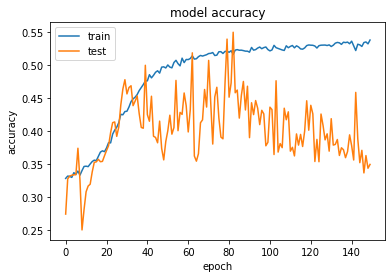

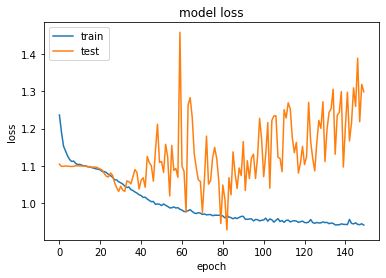

In [346]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()